#Git pull & Julia environment setup

In [ ]:
!git clone https://github.com/Peregriney/baseball_batting.git

Cloning into 'baseball_batting'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 345 (delta 129), reused 164 (delta 106), pack-reused 136 (from 1)
Receiving objects: 100% (345/345), 4.06 MiB | 7.51 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [ ]:
%cd baseball_batting

/content/baseball_batting
ablation				    dpsim-difference.png      plotquantile.jl
agg-der.jl				    histogram-comparison.png  redsox_2023.csv
agg.jl					    main.jl		      redsox_2023_lineuptop.csv
baseball_batting.ipynb			    mainv2.jl		      redsox_avgs.csv
baseball_batting_v2-3.ipynb		    nl.jl		      runtime-hist.png
baseball_batting_v2-4.ipynb		    pkgimport.jl	      sabermetriccomparison.jl
baseball-sabermetrics-deliverable-v1.ipynb  player.jl		      sim.jl
config.toml				    player-rbi.jl	      sim-player.jl
demo.jl					    playertest.jl
derivatives.jl				    plotpmf.jl


Run to download Julia and necessary packages to runtime, then proceed with rest of code.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz
  export GKSwstype=100 ;

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-11-09 19:12:33 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
!julia pkgimport.jl > install_log.txt 2>&1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import re
import subprocess

def fetch_batting_orders(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}-batting-orders.shtml#grid_table_46565'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)

        # Assuming the desired table is the first one
        df = tables[0]
        df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: remove_non_alpha(normalize_string(x)))

        df.to_csv('br-lineups.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def fetch_player_stats(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}.shtml#team_batting'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)
        #print(tables)

        # Assuming the desired table is the first one
        df = tables[0]
        df = df[df.columns[:-2]].copy()
        #print(df)
        df['Player'] = df['Player'].apply(lambda x: remove_non_alpha(normalize_string(x)))
#        df.drop([0],axis=0,inplace=True)
        df.drop(columns=['Rk', 'Pos', 'Age','G','RBI','BA','OBP','SLG','OPS','OPS+','TB','SH','SF'],inplace=True)
        #print(df)
        df = df[~df['AB'].str.contains('[a-zA-Z]', na=False)]
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
        df = df[df['AB'] > 0]
        strikeout = pd.Series(df['SO']/df['AB'])
        hits = pd.Series(df['H']/df['AB'])
        doubles = pd.Series(df['2B']/df['AB'])
        triples = pd.Series(df['3B']/df['AB'])
        homer = pd.Series(df['HR']/df['AB'])
        singles = hits - doubles - triples - homer
        if ibbinclusion:
            walks = pd.Series((df['BB'] + df['HBP'] + df['IBB'])/df['AB'])
        else:
            walks = pd.Series((df['BB'] / df['AB']))
        otherout = 1 - walks - singles - homer - triples - doubles - strikeout
        stealprob = pd.Series(df['SB']/(df['PA'] + .000000000000000000001))
        stealout = pd.Series(df['CS'] / (df['PA'] + .000000000000000000001)) #treating this NOT as conditional on trying to steal.
        gdp = pd.Series(df['GIDP']/df['AB'])
        #        df.drop(columns=['SO'], ['AB'], )
        df = df[['Player']]
        df['Strikeout'] = strikeout
        df['OO'] = otherout
        df['Walk'] = walks
        df['Single'] = singles
        df['Double'] = doubles
        df['Triple'] = triples
        df['Homer'] = homer
        df['StealSuccessProb'] = stealprob
        df['StealOutProb'] = stealout
        df['DoublePlayGroundProb'] = gdp
        df.to_csv('br-playerstats.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def normalize_string(s):
    """
    Normalize Unicode string by removing accents.
    """
    # Normalize to NFD form and remove accent marks
    return unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('ascii')

def remove_non_alpha(s):
    """
    Remove all non-alphabetic characters from the string.
    """
    #return re.sub(r'[^a-zA-Z \-]', '', s)
    return re.sub(r'[^a-zA-Z\s-]', '', s)

def clean_names(series):
    """
    Clean the names in the pandas Series by normalizing and removing non-alphabetic characters.
    """
    # Apply normalization and removal of non-alphabetic characters
    cleaned_series = series.apply(lambda x: remove_non_alpha(normalize_string(x)))
    # Convert the cleaned Series to a list
    cleaned_list = cleaned_series.tolist()
    return cleaned_list

# Function to extract score from the first column
def extract_score(text):
    match = re.search(r'\((\d+)-(\d+)\)', text)
    if match:
        return int(match.group(1))  # Return the first number
    return None

# Function to get lineup indices based on player names
def get_lineup_indices(players_str, player_index):
    #players = players_str.split('\t')[1:]  # Skip the first element
    lineup_indices = []
    #print(players_str)
    for player in players_str:
        #last_name = player.split('-')[0].strip()  # Extract the last name
        last_name = player.rsplit('-',1)[0].strip().split(' ')[-1]
        # If the last name is found in the player_index mapping
        if last_name in player_index:
            lineup_indices.append(str(player_index[last_name]))

    #print(lineup_indices)
    return str(lineup_indices)#''.join(lineup_indices)#.ljust(9, player_index[last_name])  # Ensure it's a 9-number string


def process_output(stat_df,input_df):
      #player_list = clean_names(stat_df['Name'])
      player_list = stat_df['Player']
      #player_index = {name.split(' ')[1]: idx+1 for idx, name in enumerate(player_list)}

      player_index = {
          name.split(' ')[-2] if name.split(' ')[-1] in ["Jr","II","III","IV"] else name.split(' ')[-1]: idx + 1
          for idx, name in enumerate(player_list)
      }
      # Process the data
      output_data = []
      for _, row in input_df.iterrows():
          first_column = row[0]
          second_column = row[1:]
          score = extract_score(first_column)
          lineup_indices = get_lineup_indices(second_column, player_index)
          output_data.append([score, lineup_indices])

      # Create a DataFrame for the output
      output_df = pd.DataFrame(output_data, columns=['Score', 'Lineup'])

      # Save the output DataFrame to a new CSV file
      output_df.to_csv('output.csv', index=False)
      return


In [ ]:
def extract(file_pattern):

    file_list = glob.glob(file_pattern)
    dataframes = []

    # Loop through each output file, which has empirical score, DP-score, and lineup for all games from a given team in given yr
    for file in file_list:
        print(file)
        team = file.split('_')[3]
        yr = file.split('_')[4][0:4]
        prevyr = int(yr)-1

        df = pd.read_csv(file)
        #df has columns Lineup, "Score", "Score2" already. Manually compute & add the sabermetric RC estimates.

        url = f"https://www.baseball-reference.com/teams/{team}/{yr}-batting.shtml"
        tables = pd.read_html(url)
        battingdf23 = tables[0]
        battingdf23 = battingdf23[battingdf23.columns[:-2]].copy()
        battingdf23 = battingdf23[~battingdf23['AB'].str.contains('[a-zA-Z]', na=False)].dropna()
        battingdf23.iloc[:, 4:] = battingdf23.iloc[:, 4:].astype(float)
        battingdf23['Player'] = clean_names(battingdf23['Player'])

        numrows = df.shape[0]
        teamseries = [team] * numrows
        df['team'] = teamseries

        battingdf23['saber'] = (battingdf23['H'] + battingdf23['BB']) * battingdf23['TB'] / (battingdf23['AB']+battingdf23['BB']) / battingdf23['G']


        saber23manual = []
        for i in range(numrows):
            lu = [str(re.sub(r'[^0-9]', '', x)) for x in df['Lineup'][i].replace("'","").replace("[","").replace("]","").split()]

            sumLineup22 = 0.0
            sumLineup23 = 0.0
            for playeridx in lu:

                sumLineup23 +=  (battingdf23.at[battingdf23[battingdf23['Rk'] == playeridx].index[0], 'saber'])
            saber23manual.append(sumLineup23)

        df['saber23'] = saber23manual
        dataframes.append(df)

    # Concatenate all years into a single DataFrame
    dpdf1 = pd.concat(dataframes, ignore_index=True)
    return dpdf1


# Version 2

In [ ]:
ibbinclusion = True

<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


In [ ]:
teams = ['ARI', 'ATL', 'BAL','BOS','CHC','CHW','CIN','CLE','COL','DET',
         'HOU','KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI',
         'PIT','SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN'
         ]

yr = 2023


for team in teams:
  print(team)

  input_df = fetch_batting_orders(team,yr)
  stat_df = fetch_player_stats(team,yr)
  process_output(stat_df,input_df)
  input_file = 'br-playerstats.csv'
  columns_str = '1 2 3 4 5 6 7 8 9'
  command = f"julia ablation/mainv2-special.jl {input_file} {columns_str} {team}"
  result = subprocess.run(command, shell=True, check=True, text=True, capture_output=True)
  #!julia mainv2.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9 team


ARI


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


ATL


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


BAL


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


BOS


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CHC


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CHW


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CIN


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CLE


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


COL


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


DET


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


HOU


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


HOU


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


KCR


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


LAA


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


LAD


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIA


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIL


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIN


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


NYM


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


NYY


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


OAK


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


PHI


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


PIT


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SDP


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SEA


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SFG


<ipython-input-5-9b3ba7e328f1>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


# Analysis on V2

In [ ]:
import glob
file_pattern = 'ablation/empirical/outputs_with_var_*2023.csv'
dpdf1 = extract(file_pattern)



outputs_with_var_BOS_2023.csv
outputs_with_var_KCR_2023.csv
outputs_with_var_TOR_2023.csv
outputs_with_var_BAL_2023.csv
outputs_with_var_PIT_2023.csv
outputs_with_var_CIN_2023.csv
outputs_with_var_CHW_2023.csv
outputs_with_var_ARI_2023.csv
outputs_with_var_WSN_2023.csv
outputs_with_var_DET_2023.csv
outputs_with_var_ATL_2023.csv
outputs_with_var_SFG_2023.csv
outputs_with_var_OAK_2023.csv
outputs_with_var_SDP_2023.csv
outputs_with_var_LAA_2023.csv
outputs_with_var_COL_2023.csv
outputs_with_var_SEA_2023.csv
outputs_with_var_TBR_2023.csv
outputs_with_var_STL_2023.csv
outputs_with_var_TEX_2023.csv
outputs_with_var_PHI_2023.csv
outputs_with_var_CHC_2023.csv
outputs_with_var_HOU_2023.csv
outputs_with_var_CLE_2023.csv


In [ ]:
file_pattern = 'ablation/empirical/outputs_with_score2_*2023.csv'
dpdf2 = extract(file_pattern)

outputs_with_score2_LAD_2023.csv
outputs_with_score2_MIL_2023.csv
outputs_with_score2_MIN_2023.csv
outputs_with_score2_NYY_2023.csv
outputs_with_score2_MIA_2023.csv
outputs_with_score2_NYM_2023.csv


In [ ]:
from seaborn import displot

dpdf = pd.concat([dpdf1[['Score', 'Lineup', 'score2', 'saber23', 'team']],dpdf2[['Score', 'Lineup', 'score2', 'saber23', 'team']]])
dpdf = dpdf[dpdf['score2']>0.01]
#if DP predicted score is 0-float, that means a DP was not computed and we should discard the sample.

from sklearn.metrics import r2_score
dpdfnan = dpdf.dropna()
n = dpdf['Score'].shape[0]
p = 1

dpdf['saber23'] = dpdf['saber23'].astype(float)


team_counts = dpdfnan.team.value_counts()
teams_with_at_least_150 = team_counts[team_counts >= 150].index
dpdfnan = dpdfnan[dpdfnan['team'].isin(teams_with_at_least_150)]
dpdfnan = dpdfnan.sort_values(by='team')


4.611041666666667  Empirical Mean
4.941240659199215 DP Mean


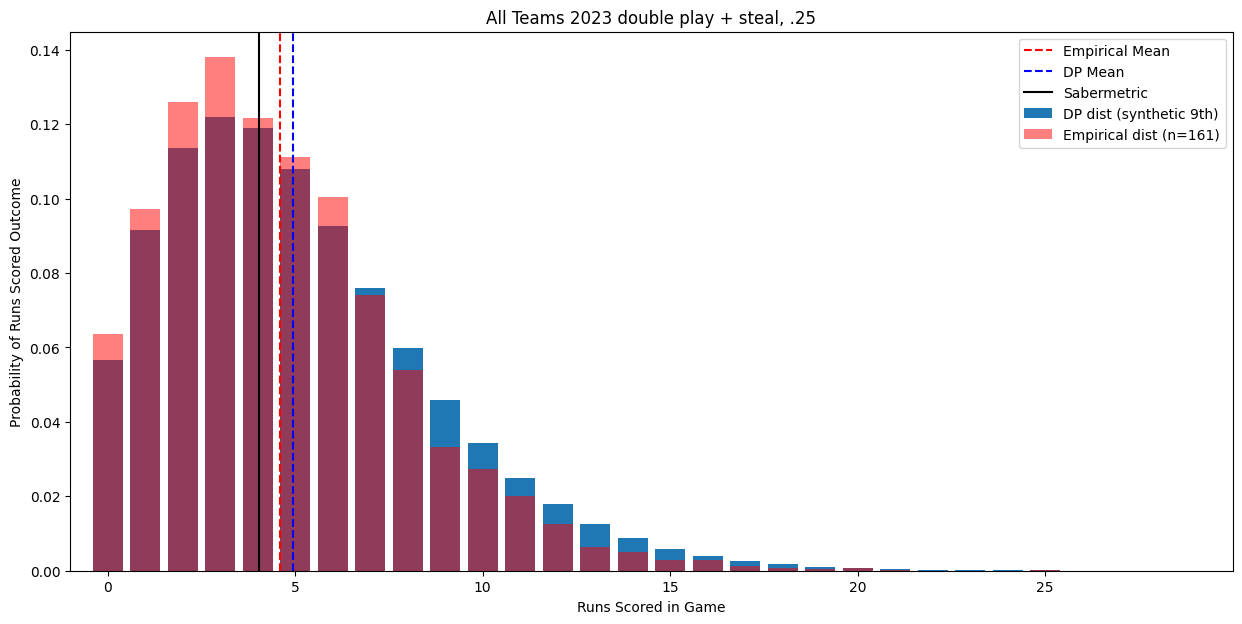

In [ ]:
#25
import matplotlib.pyplot as plt
from seaborn import histplot
import numpy as np
from collections import defaultdict
num_teams = len(dpdfnan.team.unique())

all_dp = pd.read_csv('v2_probs.csv',header=None)

all_scores = dpdfnan.groupby('team')['Score'].apply(lambda x: x[:-2]).explode().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 7))

x_positions = np.arange(0,41)
dps = []
sabers = []
dpdists = defaultdict(int)
for team in dpdfnan.team.unique():
  filtered_df = all_dp[all_dp[5] == team]
  sabers.append(dpdfnan[dpdfnan['team'] == team]['saber23'][:-2].mean())

  list_column_3 = filtered_df.iloc[0, 3].split(',')
  list_column_4 = filtered_df.iloc[0, 4].split(',')
  dps.append(float(filtered_df.iloc[0, 2]))

  list_column_3 = [int(num) for num in list_column_3]
  list_column_4 = [float(num) for num in list_column_4]
  for k, v in zip(list_column_3,list_column_4):
    dpdists[k] += v

  #ax.bar(list_column_3, list_column_4,label='DP dist (synthetic 9th)')
  #plt.hist(wsn_empirical, bins = int(wsn_empirical.max()), weights=np.ones(len(wsn_empirical)) / len(wsn_empirical),color='red',alpha=.5,label='Empirical distribution (n=161)')


ax.bar(dpdists.keys(),[v/len(dpdfnan.team.unique()) for v in dpdists.values()],label = 'DP dist (synthetic 9th)')

values, counts = np.unique(all_scores, return_counts=True)
percentages = counts / len(all_scores)
bar_counts = np.zeros(len(x_positions))
bar_counts[values.astype(int)] = percentages

ax.bar(x_positions, bar_counts, color='red', alpha=0.5, label='Empirical dist (n=161)')

#ax.hist(sabers, density=True,stacked=True)

ax.set_xticks(x_positions)
ax.set_xlim(-1, 30)
ax.set_xticks(np.arange(0, 30, 5))  # Set labels every 5
ax.set_xticklabels(np.arange(0, 30, 5))


ax.axvline(all_scores.mean(), color = 'red', ls='--',label='Empirical Mean')
ax.axvline(np.mean(dps), color = 'blue', ls='--', label='DP Mean')
ax.axvline(np.mean(sabers), color = 'black', ls = '-', label='Sabermetric')

print(all_scores.mean(), ' Empirical Mean')
print(np.mean(dps), 'DP Mean')

ax.set_xlabel('Runs Scored in Game')
ax.set_ylabel('Probability of Runs Scored Outcome')
ax.set_title('All Teams 2023 double play + steal, .25')
ax.legend()
#    ax.set_title(f'Team {team}')

plt.show()

In [ ]:
print_df = pd.DataFrame({'# of Runs Scored':dpdists.keys(),'DP Prob of Score':[v/len(dpdfnan.team.unique()) for v in dpdists.values()], 'Empirical Prob of Score': (bar_counts)})
print_df['Error'] = abs(print_df['Empirical Prob of Score'] - print_df['DP Prob of Score'])
pd.options.display.float_format = '{:20,.8f}'.format
print('Proportion of all games in 2023 ending with different runs scored, for DP vs. Empirical Distributions')

display(print_df)



Proportion of all games in 2023 ending with different runs scored, for DP vs. Empirical Distributions


,# of Runs Scored,DP Prob of Score,Empirical Prob of Score,Error
0,0,0.05668711,0.06354167,0.00685456
1,1,0.09147450,0.09729167,0.00581717
2,2,0.11344992,0.12583333,0.01238341
3,3,0.12185313,0.13791667,0.01606354
4,4,0.11882768,0.12166667,0.00283899
5,5,0.10790953,0.11125000,0.00334047
6,6,0.09264622,0.10041667,0.00777044
7,7,0.07595913,0.07416667,0.00179246
8,8,0.05995320,0.05395833,0.00599487
9,9,0.04587699,0.03333333,0.01254366


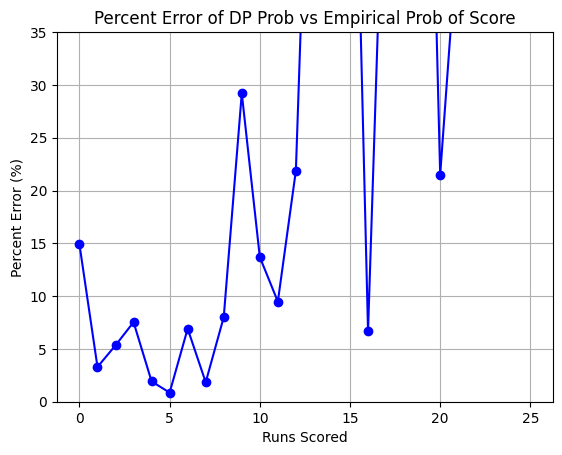

In [ ]:
print_df['Percent Error'] = (abs(print_df['DP Prob of Score'] - print_df['Empirical Prob of Score']) / print_df['Empirical Prob of Score']) * 100
plt.plot(print_df['# of Runs Scored'], print_df['Percent Error'], marker='o', linestyle='-', color='b')
plt.title('Percent Error of DP Prob vs Empirical Prob of Score')
plt.xlabel('Runs Scored')
plt.ylabel('Percent Error (%)')
plt.ylim(0,35)
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import wasserstein_distance

wd_all_scores_dps = wasserstein_distance(all_scores, dps)
wd_all_scores_sabers = wasserstein_distance(all_scores, sabers)
wd_dps_sabers = wasserstein_distance(dps, sabers)

# Create a dictionary to store the results
results = {
    'Comparison': ['Empirical vs DP', 'Empirical vs Sabermetric', 'DP vs sabermetric'],
    'Wasserstein Distance': [wd_all_scores_dps, wd_all_scores_sabers, wd_dps_sabers]
}

# Create a DataFrame from the results dictionary
df_results = pd.DataFrame(results)

# Display the DataFrame
display(df_results)

,Comparison,Wasserstein Distance
0,Empirical vs DP,1.92175205
1,Empirical vs Sabermetric,2.10708722
2,DP vs sabermetric,0.93464761


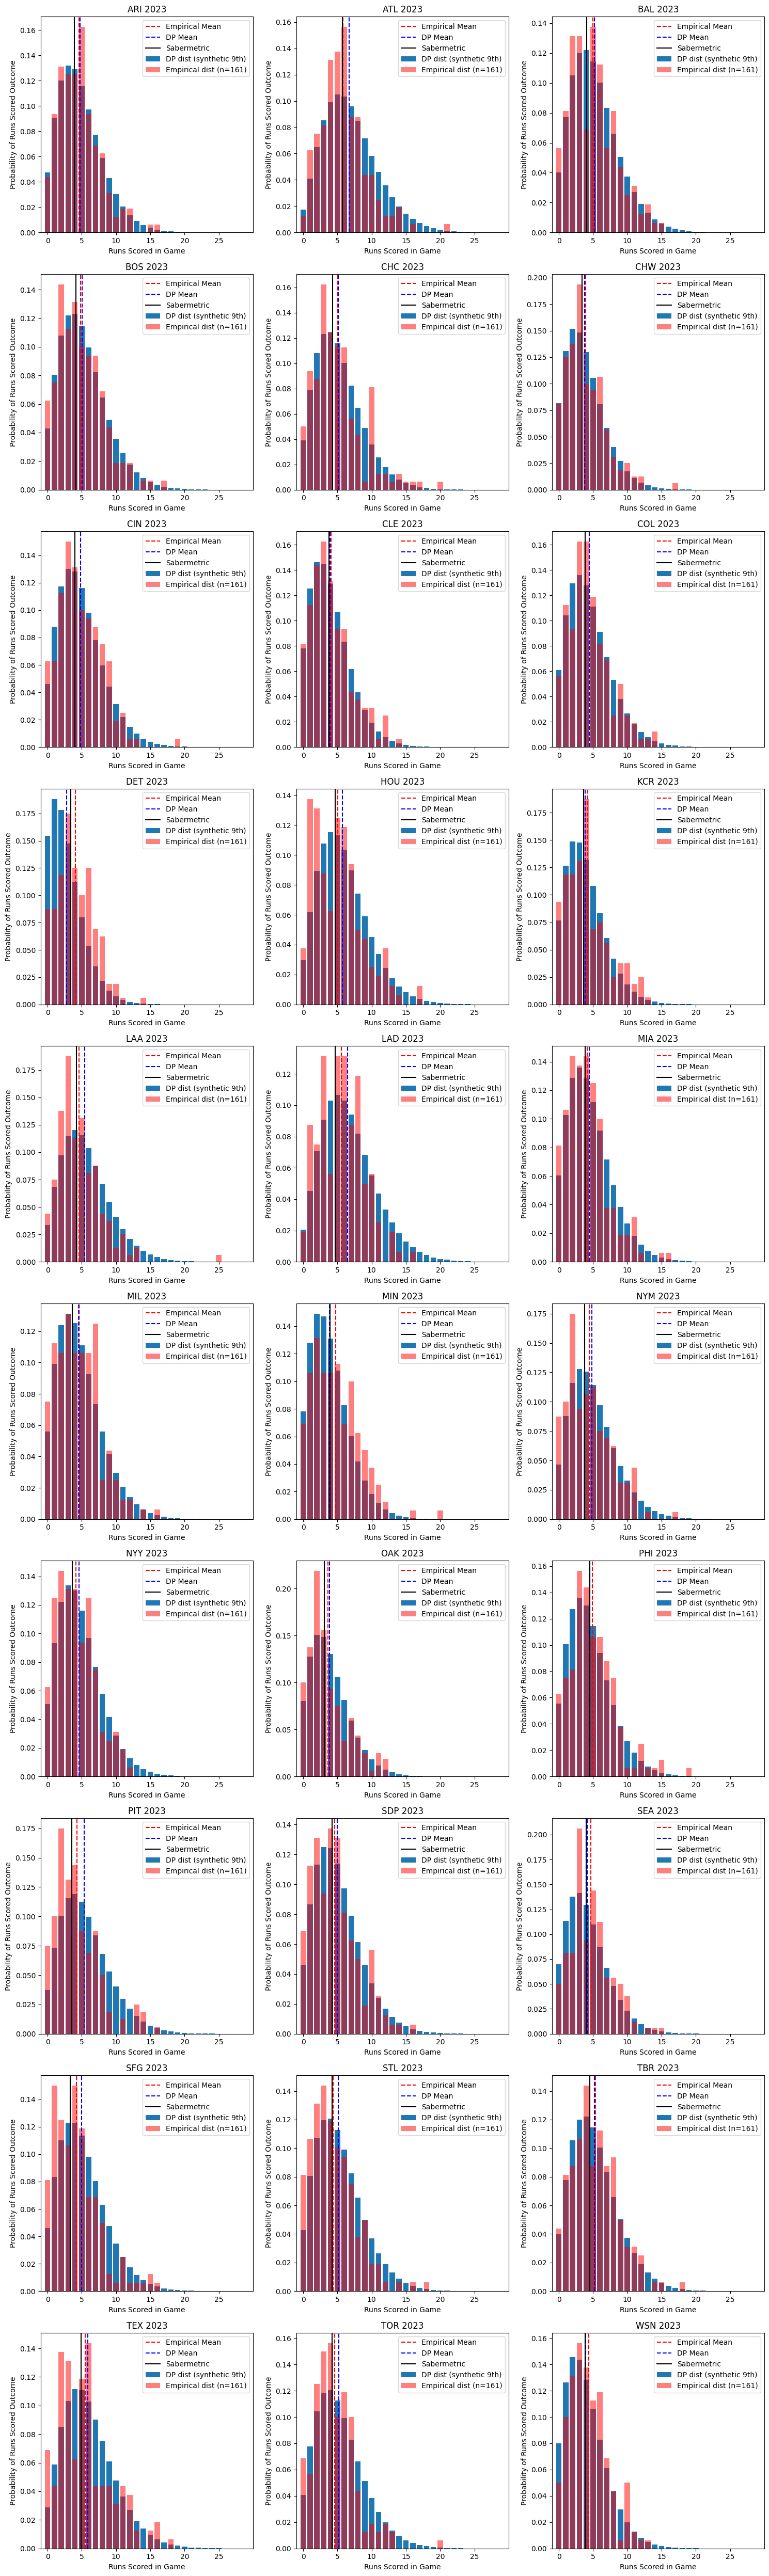

In [ ]:
num_teams = len(dpdfnan.team.unique())
cols = 3
rows = (num_teams + cols - 1) // cols  # Compute number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier
wsn_dp = pd.read_csv('v2_probs.csv',header=None)
#print(wsn_dp.iloc[0,5])
runs = []
dps = []
emps = []
teams = []
for i, team in enumerate(dpdfnan.team.unique()):

      ax = axes[i]

      wsn_empirical = dpdfnan[dpdfnan['team'] == team]['Score'][:-2]

      filtered_df = wsn_dp[wsn_dp[5] == team]

      wsn_saber = dpdfnan[dpdfnan['team'] == team]['saber23'].mean()

      list_column_3 = filtered_df.iloc[0, 3].split(',')
      list_column_4 = filtered_df.iloc[0, 4].split(',')
      dp = float(filtered_df.iloc[0, 2])


      list_column_3 = [int(num) for num in list_column_3]
      list_column_4 = [float(num) for num in list_column_4]

      ax.bar(list_column_3, list_column_4,label='DP dist (synthetic 9th)')

      x_positions = np.arange(0, 40)
      values, counts = np.unique(wsn_empirical, return_counts=True)
      percentages = counts / len(wsn_empirical)
      bar_counts = np.zeros(len(x_positions))
      bar_counts[values.astype(int)] = percentages

      ax.bar(x_positions, bar_counts, color='red', alpha=0.5, label='Empirical dist (n=161)')
      ax.set_xticks(x_positions)
      ax.set_xlim(-1, 30)
      ax.set_xticks(np.arange(0, 30, 5))
      ax.set_xticklabels(np.arange(0, 30, 5))


      ax.axvline(wsn_empirical.mean(), color = 'red', ls='--',label='Empirical Mean')
      ax.axvline(dp, color = 'blue', ls='--', label='DP Mean')
      ax.axvline(wsn_saber, color = 'black', ls = '-', label='Sabermetric')

      ax.set_xlabel('Runs Scored in Game')
      ax.set_ylabel('Probability of Runs Scored Outcome')
      ax.set_title(team + ' 2023')
      ax.legend()

      runs.append(np.arange(0,40))
      dps.append(list_column_4[:40])
      emps.append(bar_counts)
      teams.append(team)

# Hide unused subplots if there are fewer teams than the total number of subplots
for j in range(num_teams, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_teams = len(dpdfnan.team.unique())

# Create a figure with subplots
wsn_dp = pd.read_csv('v2_probs25.csv',header=None)

yrs = []
dps = []
emps = []
teams = []
sabers = []
wass = []
stddp = []
stdemp = []
stdsaber = []

for i, team in enumerate(dpdfnan.team.unique()):

      wsn_empirical = dpdfnan[dpdfnan['team'] == team]['Score'][:-2]
      filtered_df = wsn_dp[wsn_dp[5] == team]
      sab = dpdfnan[dpdfnan['team'] == team]['saber23'][:-2]
      wsn_saber = dpdfnan[dpdfnan['team'] == team]['saber23'][:-2].mean()
      list_column_3 = filtered_df.iloc[0, 3].split(',')
      list_column_4 = filtered_df.iloc[0, 4].split(',')
      dp = float(filtered_df.iloc[0, 2])

      list_column_3 = [int(num) for num in list_column_3]
      list_column_4 = [float(num) for num in list_column_4]

      x_positions = np.arange(0, 40)
      values, counts = np.unique(wsn_empirical, return_counts=True)
      percentages = counts / len(wsn_empirical)
      bar_counts = np.zeros(len(x_positions))
      bar_counts[values.astype(int)] = percentages

      w1 = wasserstein_distance(list_column_4, bar_counts)

      yrs.append(2023)
      teams.append(team)
      dps.append(dp)

      stddp.append(np.std(list_column_4))
      emps.append(wsn_empirical.mean())
      stdemp.append(np.std(wsn_empirical))
      sabers.append(wsn_saber)
      stdsaber.append(np.std(sab))
      wass.append(w1)


#Tabulation team-wise
df = pd.DataFrame({
    'Year': yrs,
    'Team': teams,
    'Empirical': emps,
    'Emp st.dev': stdemp,
    'DP': dps,
    'DP st.dev': stddp,
    'Saber': sabers,
    'Saber st.dev': stdsaber,
    'Wasserstein (Empirical-DP)': wass
    })

df['better'] = df.apply(
    lambda row: 'DP' if abs(row['DP'] - row['Empirical']) < abs(row['Saber'] - row['Empirical']) else 'Saber',
    axis=1
)

display(df)
#df.to_csv('teams-2023.csv')

,Year,Team,Empirical,Emp st.dev,DP,DP st.dev,Saber,Saber st.dev,Wasserstein (Empirical-DP),better
0,2023,ARI,4.64375000,2.97772328,4.60557302,0.04135750,3.92360876,0.27121793,0.00311135,DP
1,2023,ATL,5.80000000,3.28595496,6.96707203,0.03393083,5.73084928,0.32170327,0.00664417,Saber
2,2023,BAL,5.00625000,3.29487647,5.24687080,0.03863772,4.07556005,0.27502753,0.00332679,DP
3,2023,BOS,4.71875000,3.22329776,5.30600793,0.03839462,4.10333217,0.29273317,0.00365569,DP
4,2023,CHC,5.08125000,3.63657097,5.12014491,0.03928187,4.29367310,0.37310044,0.00373352,DP
5,2023,CHW,3.97500000,2.92606818,3.87939122,0.04482130,3.42039183,0.26757892,0.00345747,DP
6,2023,CIN,4.82500000,3.09344064,4.80255392,0.04041294,4.00757320,0.45256404,0.00332809,DP
7,2023,CLE,4.10000000,2.98998328,4.00614033,0.04383739,3.77694923,0.34692986,0.00324864,DP
8,2023,COL,4.43750000,2.99100213,4.59915261,0.04109561,3.86351987,0.27031775,0.00358409,DP
9,2023,DET,4.06875000,2.68123543,2.73342279,0.05269593,3.40788138,0.26075272,0.00755316,Saber


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1BCmrJHomMpaBm910KEO5etxj7iuHHEhsD856piIMqCg#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


When calculating the possible game outcomes with DP, we only consider one subset of 9 players (where 8 are real players, chosen from the first game of season), and the 9th is a synthetic player meant to bring the 9-player batting lineup to the team season average.

However, this ordering is typically not optimal. When comparing the mean of all empirical scores on real-world games, vs. the mean of DP expected score computed on all real-world games, we find that DP and empirical have low MAE.
